#### Lorenz系统的msf

In [1]:
import os
import sys
sys.path.append(r"../")
import numpy as np
import matplotlib.pyplot as plt
from numba import njit, prange
from import_fun import mLCE_jit, LCE_jit

In [2]:
@njit
def f(x, t, gamma):
    # 常量参数
    sigma = 10.
    rho = 28.
    beta = 2

    res = np.zeros_like(x)
    res[0] = sigma * (x[1] - x[0])
    res[1] = x[0] * (rho - x[2]) - x[1]
    res[2] = x[0] * x[1] - beta * x[2]
    return res

@njit
def jac(x, t, gamma):
    # 常量参数
    sigma = 10.
    rho = 28.
    beta = 2

    res = np.zeros((x.shape[0], x.shape[0]))
    res[0, 0], res[0, 1] = -sigma, sigma
    res[1, 0], res[1, 1], res[1, 2] = rho - x[2], -1., -x[0]
    res[2, 0], res[2, 1], res[2, 2] = x[1], x[0], -beta

    DH = np.zeros((x.shape[0], x.shape[0]))
    # DH[0, 0] = 1   # 1-->1
    # DH[1, 0] = 1   # 1-->2
    DH[0, 1] = 1   # 2-->1
    # DH[2, 2] = 1   # 3-->3
    
    return res - gamma * DH

In [3]:
x0 = np.array([1.5, -1.5, 20.])
dt = 1e-2
T_init = int(5e4)
T_cal = int(1e6)
gamma_list = np.arange(0.01, 30, .05)

In [4]:
@njit(parallel=True)
def parallel_msf_mLCE(gamma_list, x0, f, jac, T_init, T_cal, dt):
    n = len(gamma_list)
    mLCE_values = np.zeros(n)
    for i in prange(n):
        gamma = gamma_list[i]
        mLCE_values[i] = mLCE_jit(x0, f, jac, T_init, T_cal, dt, gamma)

    return mLCE_values

In [5]:
mLCE_values = parallel_msf_mLCE(gamma_list, x0, f, jac, T_init, T_cal, dt)

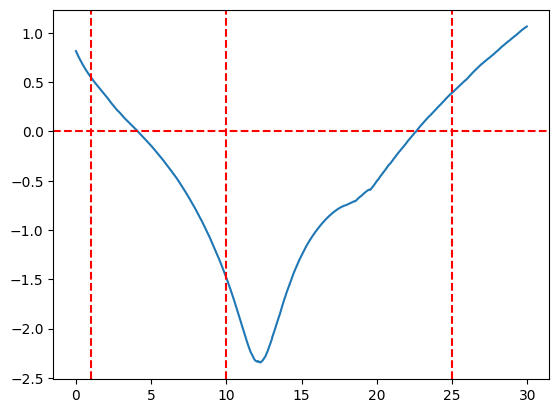

In [6]:
plt.plot(gamma_list, mLCE_values)
plt.axhline(y=0, color='r', linestyle='--')
plt.axvline(x=1, color='r', linestyle='--')
plt.axvline(x=10, color='r', linestyle='--')
plt.axvline(x=25, color='r', linestyle='--')
plt.show()